In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from datetime import datetime
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape, Flatten

In [ ]:
# Función para graficar series temporales
def plot_series(time, series, format="-", start=0, end=None, title="", xlabel="", ylabel=""):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)


In [ ]:
# Carga del dataset
df = pd.read_csv('/content/ETF prices.csv')
print("Primeras filas del dataset: \n")
print(df.head(30))

Primeras filas del dataset: 

   fund_symbol  price_date   open   high    low  close  adj_close    volume
0          AAA  2020-09-09  25.10  25.12  25.07  25.07      24.85   17300.0
1          AAA  2020-09-10  25.06  25.07  25.05  25.07      24.85   23500.0
2          AAA  2020-09-11  25.04  25.05  25.02  25.03      24.81   33400.0
3          AAA  2020-09-14  25.01  25.06  25.01  25.02      24.80   13100.0
4          AAA  2020-09-15  25.02  25.03  25.01  25.01      24.79   12100.0
5          AAA  2020-09-16  24.97  24.98  24.97  24.97      24.75   14100.0
6          AAA  2020-09-17  24.99  25.00  24.98  24.98      24.76   15200.0
7          AAA  2020-09-18  24.97  24.98  24.97  24.98      24.76    5300.0
8          AAA  2020-09-21  24.99  24.99  24.98  24.98      24.76    8600.0
9          AAA  2020-09-22  24.98  24.99  24.98  24.98      24.76    8100.0
10         AAA  2020-09-23  24.99  25.00  24.99  24.99      24.77    4400.0
11         AAA  2020-09-24  24.99  24.99  24.98  24.98    

In [ ]:
# Limpiar la sesión y fijar semillas para reproducibilidad
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

El dataset tiene los siguientes fondos:

- 'AAA'
- 'AAAU'
- 'AADR'
- 'ZIVZF'
- 'ZROZ'
- 'ZSL'
- 'FEUZ'

Entre otros

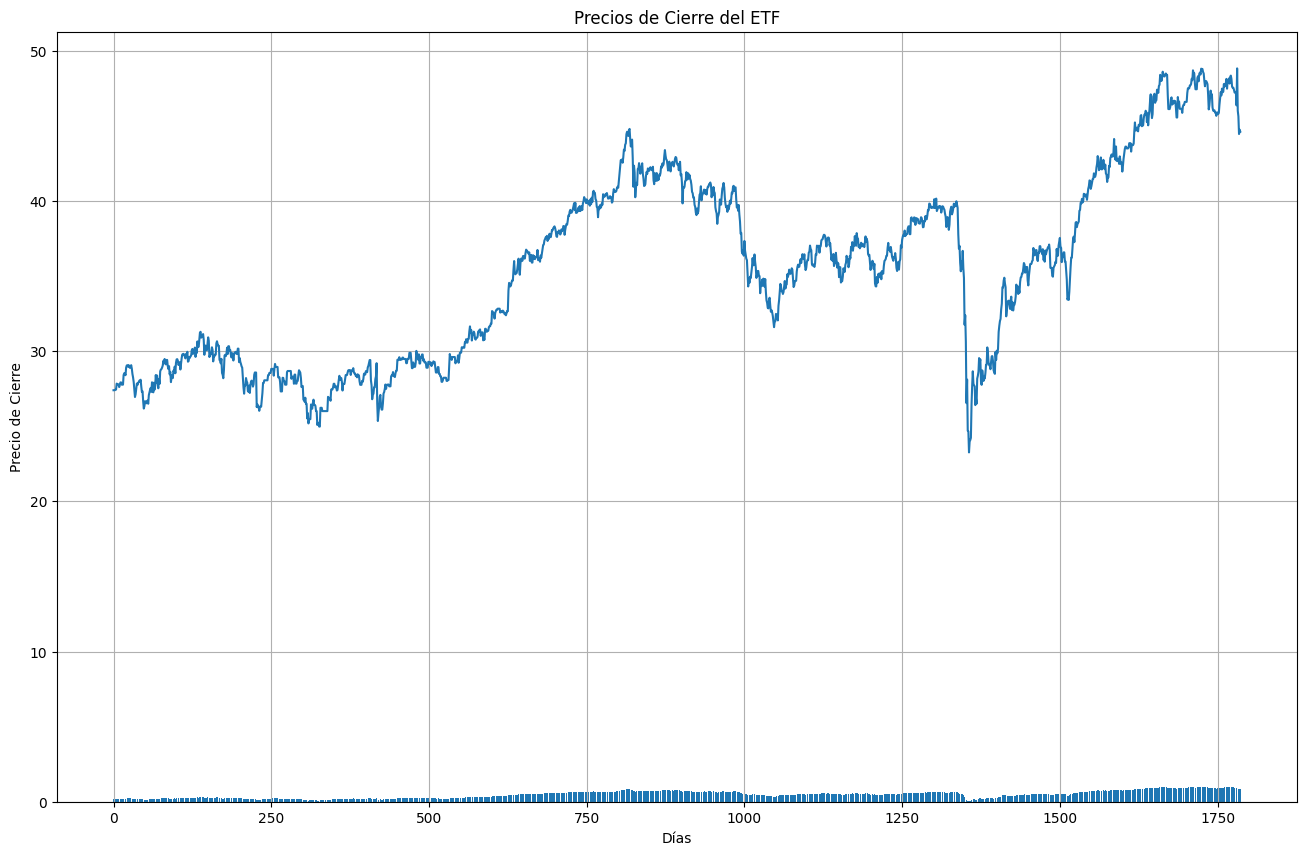

In [ ]:
# Filtrar datos para un fondo específico

time_step = []
prices = []

# Símbolo del fondo que se desea filtrar
fund_symbol = "FEUZ" # Fondo seleccionado

with open('/content/ETF prices.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # Omitir la primera fila (encabezados)
    step=0
    for row in reader:
        if row[0] == fund_symbol:
            prices.append(float(row[6]))  # Agregar el precio de cierre a la lista prices (columna 6)
            time_step.append(step)  # Agregar el paso de tiempo a la lista time_step
            step = step + 1

if not prices:
    print(f"No se encontraron datos para el fondo {fund_symbol}")
else:
    # Convertir las listas en arreglos NumPy
    series = np.array(prices)
    time = np.array(time_step)

    # Normalizar los datos
    min_series = np.min(series)
    max_series = np.max(series)
    series = (series - min_series) / (max_series - min_series)

    # Graficar los datos originales
    plt.figure(figsize=(16, 10))
    plt.bar(time_step, series, width=0.8)
    plot_series(time_step, prices, title="Precios de Cierre del ETF", xlabel="Días", ylabel="Precio de Cierre")
    plt.show()

In [ ]:
#Division de entrenamiento y validacion
train_division = 0.8

#Variables para la técnica de la ventana temporal

split_time = int(len(series) * train_division)
window_size = 60  # Aumentado de 30 a 60
batch_size = 32
shuffle_buffer_size = 1000

#Creamos las variables de entrenamiento y validacion
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


In [ ]:
# Función para crear dataset con ventana temporal
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
 series = tf.expand_dims(series, axis=-1)
 ds = tf.data.Dataset.from_tensor_slices(series)
 ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
 ds = ds.flat_map(lambda w: w.batch(window_size + 1))
 ds = ds.shuffle(shuffle_buffer)
 ds = ds.map(lambda w: (w[:-1], w[1:]))
 return ds.batch(batch_size).prefetch(1)

In [ ]:
#Creacion del conjunto de entrenamiento y validación usando la funcion windowed_dataset
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

# Verificar el contenido de los datasets
for element in train_set.take(1):
    print("Elemento de train_set:", element)
for element in val_set.take(1):
    print("Elemento de val_set:", element)

Elemento de train_set: (<tf.Tensor: shape=(32, 60, 1), dtype=float64, numpy=
array([[[0.13648807],
        [0.1544779 ],
        [0.18068048],
        ...,
        [0.18615565],
        [0.2014079 ],
        [0.21392257]],

       [[0.70277669],
        [0.69612828],
        [0.66445053],
        ...,
        [0.50449746],
        [0.50058662],
        [0.46617129]],

       [[0.18771998],
        [0.18771998],
        [0.18771998],
        ...,
        [0.17285882],
        [0.17285882],
        [0.13727024]],

       ...,

       [[0.71098944],
        [0.72663277],
        [0.71372702],
        ...,
        [0.70160344],
        [0.68987094],
        [0.66288619]],

       [[0.12006257],
        [0.11145874],
        [0.11145874],
        ...,
        [0.25420415],
        [0.25420415],
        [0.2412984 ]],

       [[0.20805632],
        [0.11810716],
        [0.12553774],
        ...,
        [0.19710598],
        [0.19710598],
        [0.19710598]]])>, <tf.Tensor: shape=(32, 60,

In [ ]:
## Creación y compilación del modelo LSTM
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [ ]:
# Compilacion del modelo LSTM
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

'''
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)
'''

'\nmodel.compile(\n    loss=tf.keras.losses.Huber(),\n    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),\n    metrics=[tf.keras.metrics.MeanAbsoluteError()]\n)\n'

In [ ]:
# Early stopping para LSTM
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


In [ ]:
## Plan de tasas de aprendizaje para crear la variable lr_schedule en LSTM
def lr_schedule(epoch):
    initial_lr = 1e-6
    drop = 0.5
    epochs_drop = 10.0
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)


In [ ]:
# Entrenamiento del modelo LSTM
print("Iniciando el entrenamiento del modelo...")
history = model.fit(train_set, epochs=150, validation_data=val_set, callbacks=[early_stopping])
print("Entrenamiento completado.")


Iniciando el entrenamiento del modelo...
Epoch 1/150
43/43 [==============================] - 9s 38ms/step - loss: 2.5075 - mean_absolute_error: 0.2121 - val_loss: 2.3935 - val_mean_absolute_error: 0.2185
Epoch 2/150
43/43 [==============================] - 1s 13ms/step - loss: 2.2603 - mean_absolute_error: 0.0953 - val_loss: 2.1676 - val_mean_absolute_error: 0.1333
Epoch 3/150
43/43 [==============================] - 1s 13ms/step - loss: 2.0561 - mean_absolute_error: 0.0782 - val_loss: 1.9680 - val_mean_absolute_error: 0.0996
Epoch 4/150
43/43 [==============================] - 1s 14ms/step - loss: 1.8699 - mean_absolute_error: 0.0645 - val_loss: 1.7879 - val_mean_absolute_error: 0.0833
Epoch 5/150
43/43 [==============================] - 1s 13ms/step - loss: 1.6998 - mean_absolute_error: 0.0553 - val_loss: 1.6238 - val_mean_absolute_error: 0.0723
Epoch 6/150
43/43 [==============================] - 1s 13ms/step - loss: 1.5446 - mean_absolute_error: 0.0503 - val_loss: 1.4743 - val_mea

In [ ]:
# Función para realizar predicciones con el modelo LSTM
def model_forecast(model, series, window_size):

 #Creacion de la variable con el valor resultante de from_tensor_slices
 ds = tf.data.Dataset.from_tensor_slices(series)
 #Definicion de la ventana de la serie
 ds = ds.window(window_size, shift=1, drop_remainder=True)
 #Creacion del flat_map
 ds = ds.flat_map(lambda w: w.batch(window_size))
 #Dividimos el lote y el prefetch
 ds= ds.batch(32).prefetch(1)
 #Prediccion del modelo
 forecast = model.predict(ds)
 return forecast

In [ ]:
# Predicciones del modelo LSTM
print("Realizando predicciones con el modelo...")
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
print("Predicciones realizadas.")

Realizando predicciones con el modelo...
54/54 [==============================] - 1s 5ms/step
Predicciones realizadas.


In [ ]:
# Desnormalizar las predicciones LSTM
rnn_forecast = rnn_forecast * (max_series - min_series) + min_series
x_valid_denorm = x_valid * (max_series - min_series) + min_series

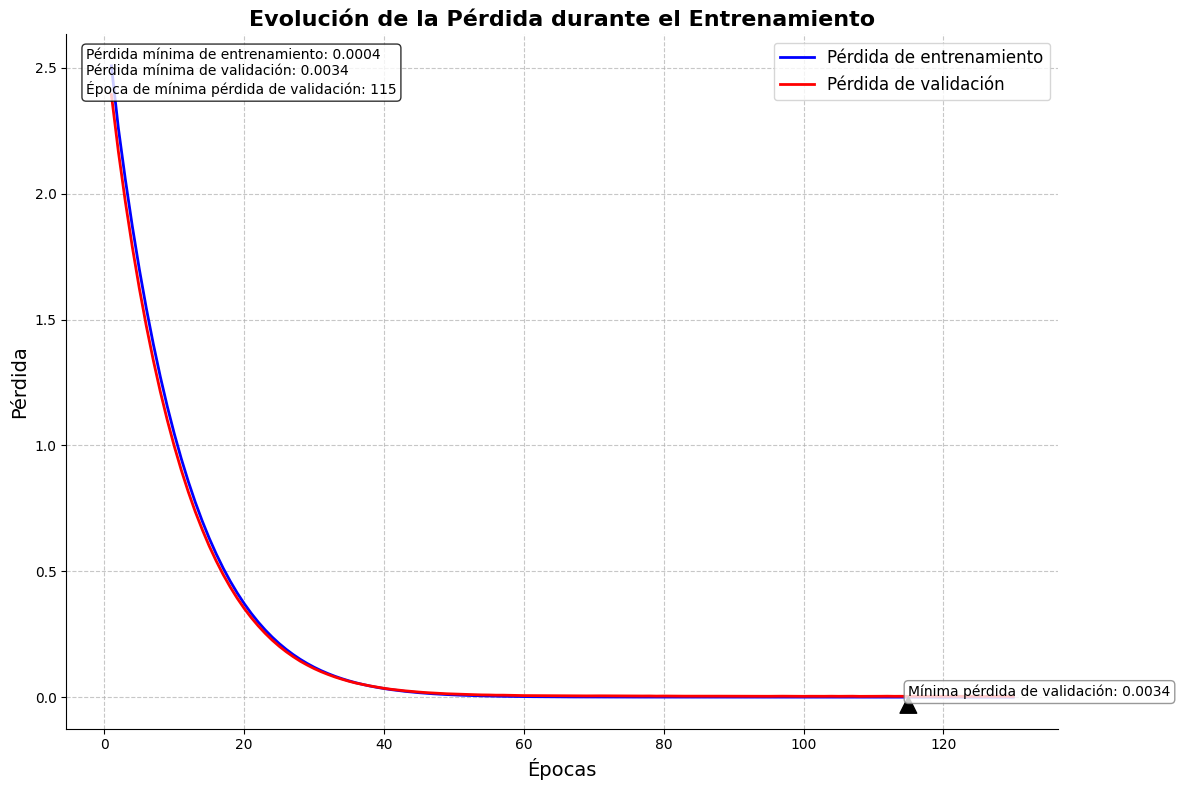

In [ ]:
# gráfica de pérdida del entrenamiento LSTM
plt.figure(figsize=(12, 8))
epochs = range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], 'b-', linewidth=2, label='Pérdida de entrenamiento')
plt.plot(epochs, history.history['val_loss'], 'r-', linewidth=2, label='Pérdida de validación')

plt.title('Evolución de la Pérdida durante el Entrenamiento', fontsize=16, fontweight='bold')
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Pérdida', fontsize=14)

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

min_train_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])
epoch_min_val_loss = history.history['val_loss'].index(min_val_loss) + 1

plt.annotate(f'Mínima pérdida de validación: {min_val_loss:.4f}',
             xy=(epoch_min_val_loss, min_val_loss),
             xytext=(epoch_min_val_loss, min_val_loss*1.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.text(0.02, 0.98, f'Pérdida mínima de entrenamiento: {min_train_loss:.4f}\n'
                     f'Pérdida mínima de validación: {min_val_loss:.4f}\n'
                     f'Época de mínima pérdida de validación: {epoch_min_val_loss}',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

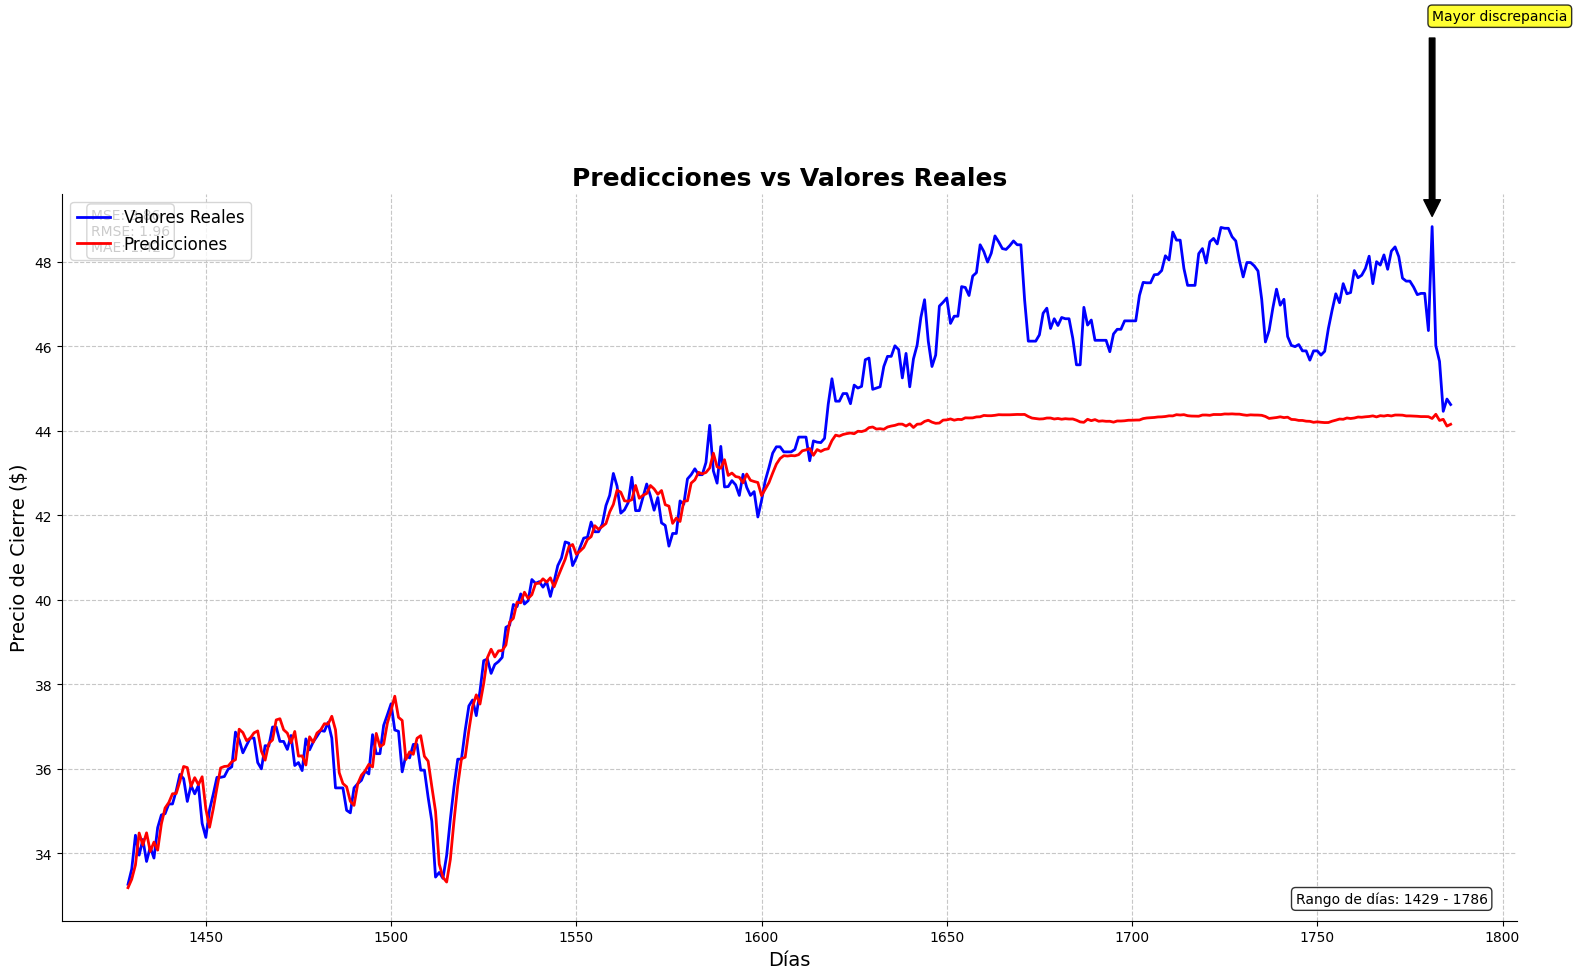

In [ ]:
# Graficar predicciones vs valores reales en días del modelo LSTM
plt.figure(figsize=(16, 10))

# Asumiendo que time_valid es una serie de números representando días
days = time_valid

# Graficar los valores reales
plt.plot(days, x_valid_denorm, 'b-', linewidth=2, label='Valores Reales')

# Graficar las predicciones
plt.plot(days, rnn_forecast, 'r-', linewidth=2, label='Predicciones')

plt.title("Predicciones vs Valores Reales", fontsize=18, fontweight='bold')
plt.xlabel("Días", fontsize=14)
plt.ylabel("Precio de Cierre ($)", fontsize=14)

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Remover los bordes superiores y derechos
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar los ticks del eje x
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Calcular y mostrar métricas de rendimiento
mse = np.mean((x_valid_denorm - rnn_forecast)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(x_valid_denorm - rnn_forecast))

plt.text(0.02, 0.98, f'MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Resaltar algunas áreas de interés
max_diff_index = np.argmax(np.abs(x_valid_denorm - rnn_forecast))
plt.annotate('Mayor discrepancia',
             xy=(days[max_diff_index], x_valid_denorm[max_diff_index]),
             xytext=(days[max_diff_index], x_valid_denorm[max_diff_index]*1.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", alpha=0.8))

# Añadir información sobre el rango de días
plt.text(0.98, 0.02, f'Rango de días: {min(days)} - {max(days)}',
         transform=plt.gca().transAxes, fontsize=10,
         horizontalalignment='right', verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

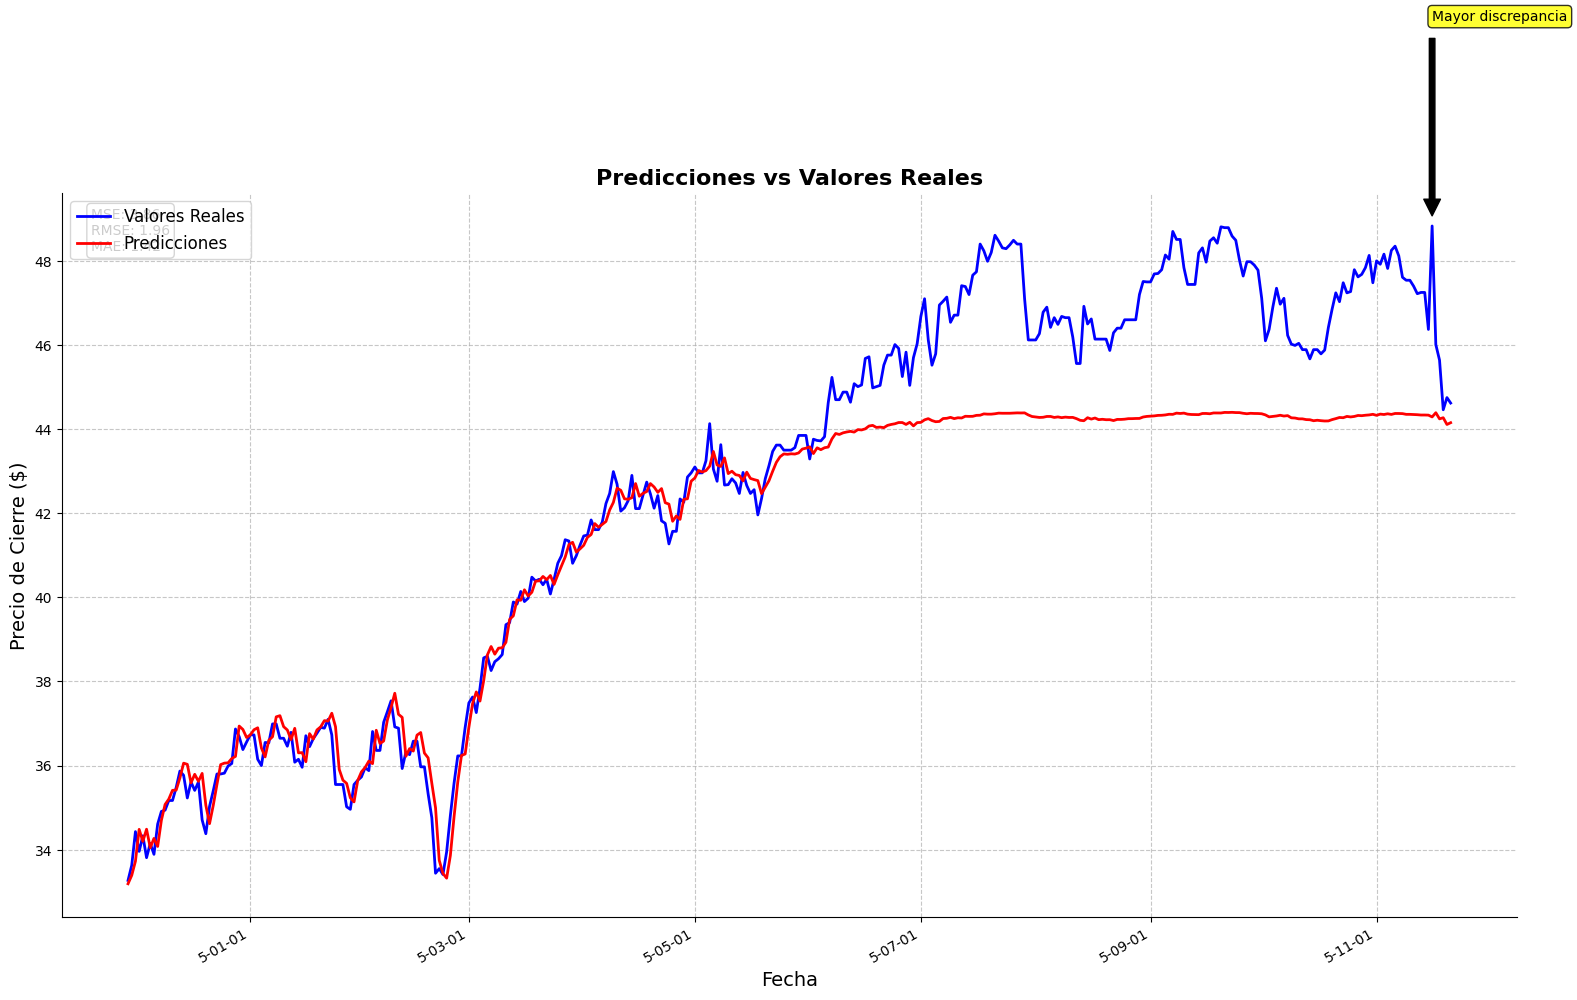

In [ ]:
# Graficar predicciones vs valores realescon fechas del modelo LSTM
plt.figure(figsize=(16, 10))

# Convertir time_valid a fechas si no lo está ya
if not isinstance(time_valid[0], datetime):
    time_valid = [datetime.fromordinal(int(t)) for t in time_valid]

plt.plot(time_valid, x_valid_denorm, 'b-', linewidth=2, label='Valores Reales')
plt.plot(time_valid, rnn_forecast, 'r-', linewidth=2, label='Predicciones')

plt.title("Predicciones vs Valores Reales", fontsize=16, fontweight='bold')
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Precio de Cierre ($)", fontsize=14)

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Formatear el eje x para mostrar fechas de manera legible
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()  # Rotar y alinear las etiquetas de fecha

# Calcular y mostrar métricas de rendimiento
mse = np.mean((x_valid_denorm - rnn_forecast)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(x_valid_denorm - rnn_forecast))

plt.text(0.02, 0.98, f'MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Resaltar algunas áreas de interés (por ejemplo, la mayor discrepancia)
max_diff_index = np.argmax(np.abs(x_valid_denorm - rnn_forecast))
plt.annotate('Mayor discrepancia',
             xy=(time_valid[max_diff_index], x_valid_denorm[max_diff_index]),
             xytext=(time_valid[max_diff_index], x_valid_denorm[max_diff_index]*1.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", alpha=0.8))

plt.tight_layout()
plt.show()

In [ ]:
# Evaluación del modelo LSTM
mae = tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
print(f"Error Absoluto Medio (MAE) en el conjunto de validación: {mae:.2f}")

Error Absoluto Medio (MAE) en el conjunto de validación: 40.67


In [ ]:
# Modelo GAN
def build_generator(latent_dim, data_dim):
    model = tf.keras.Sequential([
        Dense(128, activation="relu", input_dim=latent_dim),
        Dense(256, activation="relu"),
        Dense(512, activation="relu"),
        Dense(data_dim, activation="tanh"),
        Reshape((data_dim,))
    ])
    return model

def build_discriminator(data_dim):
    model = tf.keras.Sequential([
        Flatten(input_shape=(data_dim,)),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    return model

In [ ]:
atent_dim = 100
data_dim = len(prices)  # Utilizar la longitud de la serie temporal como dimensión de los datos

generator = build_generator(latent_dim, data_dim)
discriminator = build_discriminator(data_dim)
discriminator.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

gan_model = tf.keras.Sequential([generator, discriminator])
discriminator.trainable = False
gan_model.compile(optimizer="adam", loss="binary_crossentropy")

# Entrenamiento GAN
def train_gan(gan_model, data, batch_size, latent_dim, epochs):
    d_losses_real, d_losses_fake, g_losses = [], [], []

    for epoch in range(epochs):
        for _ in range(batch_size):
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            generated_data = generator.predict(noise)
            real_data = data[np.random.randint(0, data.shape[0], batch_size)]

            labels_real = np.ones((batch_size, 1))
            labels_fake = np.zeros((batch_size, 1))

            d_loss_real = discriminator.train_on_batch(real_data, labels_real)
            d_loss_fake = discriminator.train_on_batch(generated_data, labels_fake)

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            labels_gan = np.ones((batch_size, 1))
            g_loss = gan_model.train_on_batch(noise, labels_gan)

        d_losses_real.append(d_loss_real)
        d_losses_fake.append(d_loss_fake)
        g_losses.append(g_loss)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, G Loss: {g_loss}")

    return d_losses_real, d_losses_fake, g_losses

In [ ]:
# Normalizar los datos de precios para entrenar el GAN
prices = np.array(prices)
prices = (prices - np.min(prices)) / (np.max(prices) - np.min(prices))

In [ ]:
# Convertir los datos de precios para entrenar el GAN
def preprocess_for_gan(prices):
    prices = prices.reshape(-1, data_dim)  # Remodelar a (n_samples, data_dim)
    return prices

gan_dataset = preprocess_for_gan(prices)
d_losses_real, d_losses_fake, g_losses = train_gan(gan_model, gan_dataset, batch_size=32, latent_dim=100, epochs=100)

# Generar datos sintéticos y evaluar
noise = np.random.normal(0, 1, (100, latent_dim))
generated_prices = generator.predict(noise)

1/1 [==============================] - 0s 17ms/step
Epoch: 0, D Loss Real: [0.00044452090514823794, 1.0], D Loss Fake: [0.00392422080039978, 1.0], G Loss: 6.74263858795166
1/1 [==============================] - 0s 18ms/step
Epoch: 10, D Loss Real: [0.5363559126853943, 1.0], D Loss Fake: [0.8824981451034546, 0.25], G Loss: 2.6181187629699707
1/1 [==============================] - 0s 18ms/step
Epoch: 20, D Loss Real: [0.7070077657699585, 0.0], D Loss Fake: [0.2741180956363678, 1.0], G Loss: 4.584659576416016
1/1 [==============================] - 0s 18ms/step
Epoch: 30, D Loss Real: [0.2966485619544983, 1.0], D Loss Fake: [0.24764901399612427, 1.0], G Loss: 2.4474825859069824
1/1 [==============================] - 0s 18ms/step
Epoch: 40, D Loss Real: [0.3279303312301636, 1.0], D Loss Fake: [0.16970109939575195, 1.0], G Loss: 2.8841962814331055
1/1 [==============================] - 0s 17ms/step
Epoch: 50, D Loss Real: [0.45819956064224243, 1.0], D Loss Fake: [0.2710238993167877, 1.0], G 

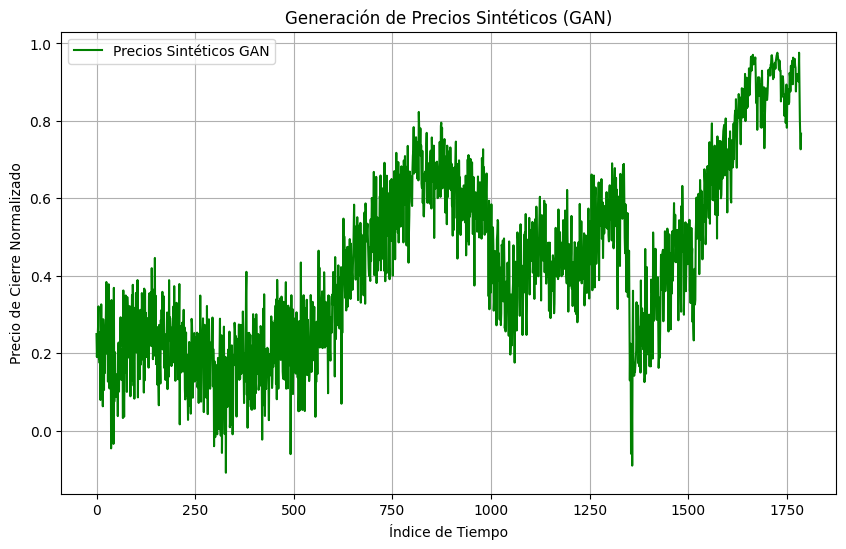

In [ ]:
# Graficar modelo GAN

plt.figure(figsize=(10, 6))
plt.plot(generated_prices[0], label='Precios Sintéticos GAN', color='green')
plt.title('Generación de Precios Sintéticos (GAN)')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Precio de Cierre Normalizado')
plt.legend()
plt.grid(True)
plt.show()

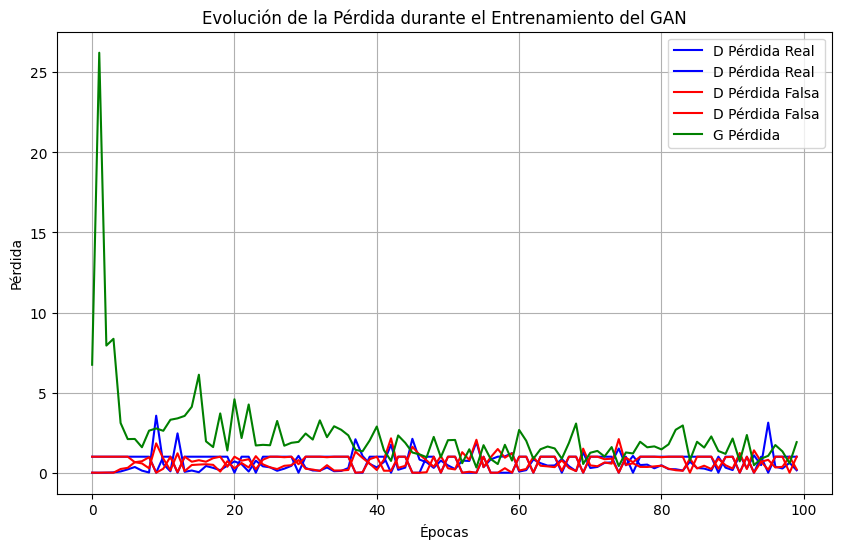

In [ ]:
# Graficar la evolución de la pérdida durante el entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(d_losses_real, label='D Pérdida Real', color='blue')
plt.plot(d_losses_fake, label='D Pérdida Falsa', color='red')
plt.plot(g_losses, label='G Pérdida', color='green')
plt.title('Evolución de la Pérdida durante el Entrenamiento del GAN')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

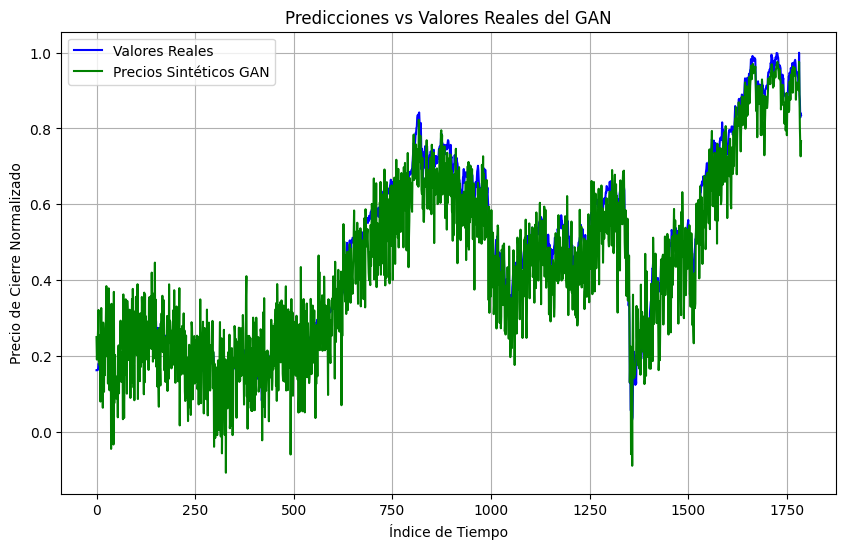

In [ ]:
# Graficar las predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.plot(prices, label='Valores Reales', color='blue')
plt.plot(generated_prices[0], label='Precios Sintéticos GAN', color='green')
plt.title('Predicciones vs Valores Reales del GAN')
plt.xlabel('Índice de Tiempo')
plt.ylabel('Precio de Cierre Normalizado')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 2000x1000 with 0 Axes>

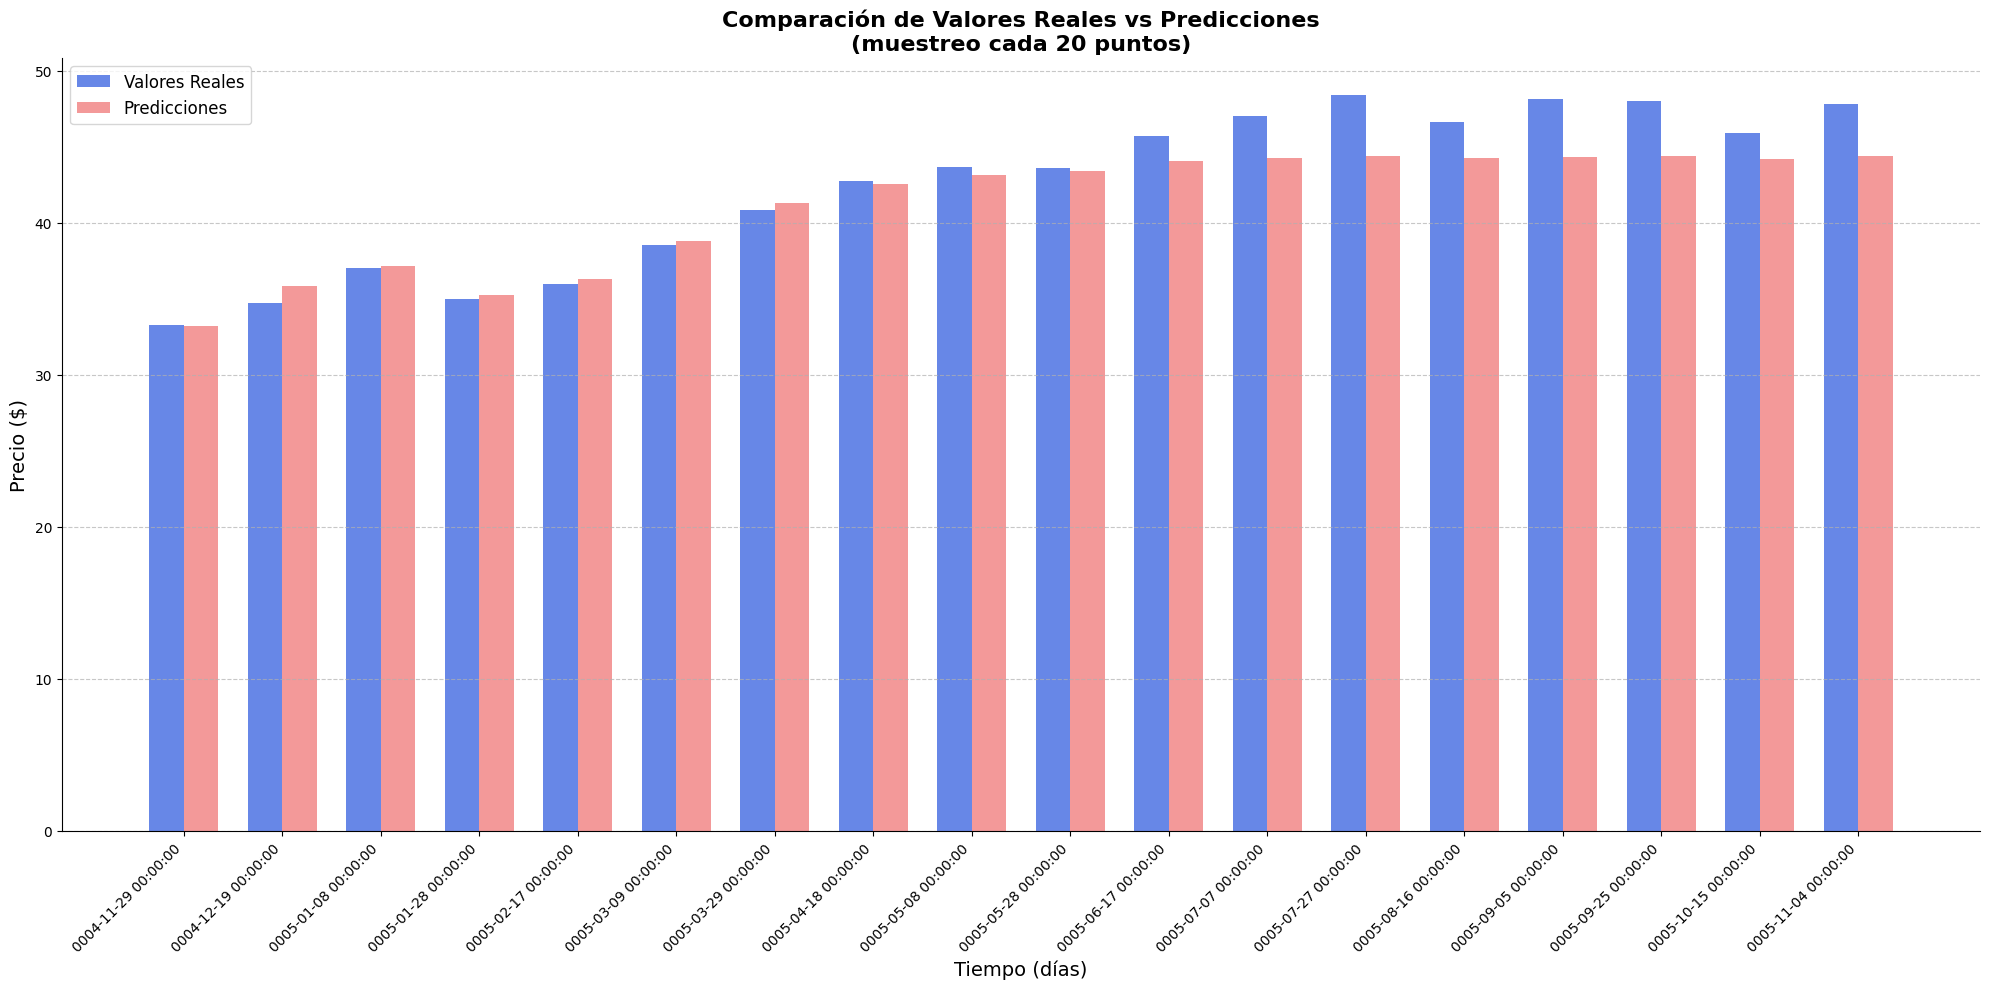

In [ ]:
# Comparación de valores reales vs predicciones con gráficos de barras
plt.figure(figsize=(20, 10))
ind = np.arange(0, len(time_valid[::20]), 1)
width = 0.35

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.bar(ind - width/2, x_valid_denorm[::20], width, label='Valores Reales', color='royalblue', alpha=0.8)
rects2 = ax.bar(ind + width/2, rnn_forecast[::20], width, label='Predicciones', color='lightcoral', alpha=0.8)

ax.set_xlabel('Tiempo (días)', fontsize=14)
ax.set_ylabel('Precio ($)', fontsize=14)
ax.set_title('Comparación de Valores Reales vs Predicciones\n(muestreo cada 20 puntos)', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)

ax.set_xticks(ind)
ax.set_xticklabels(time_valid[::20], rotation=45, ha='right')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

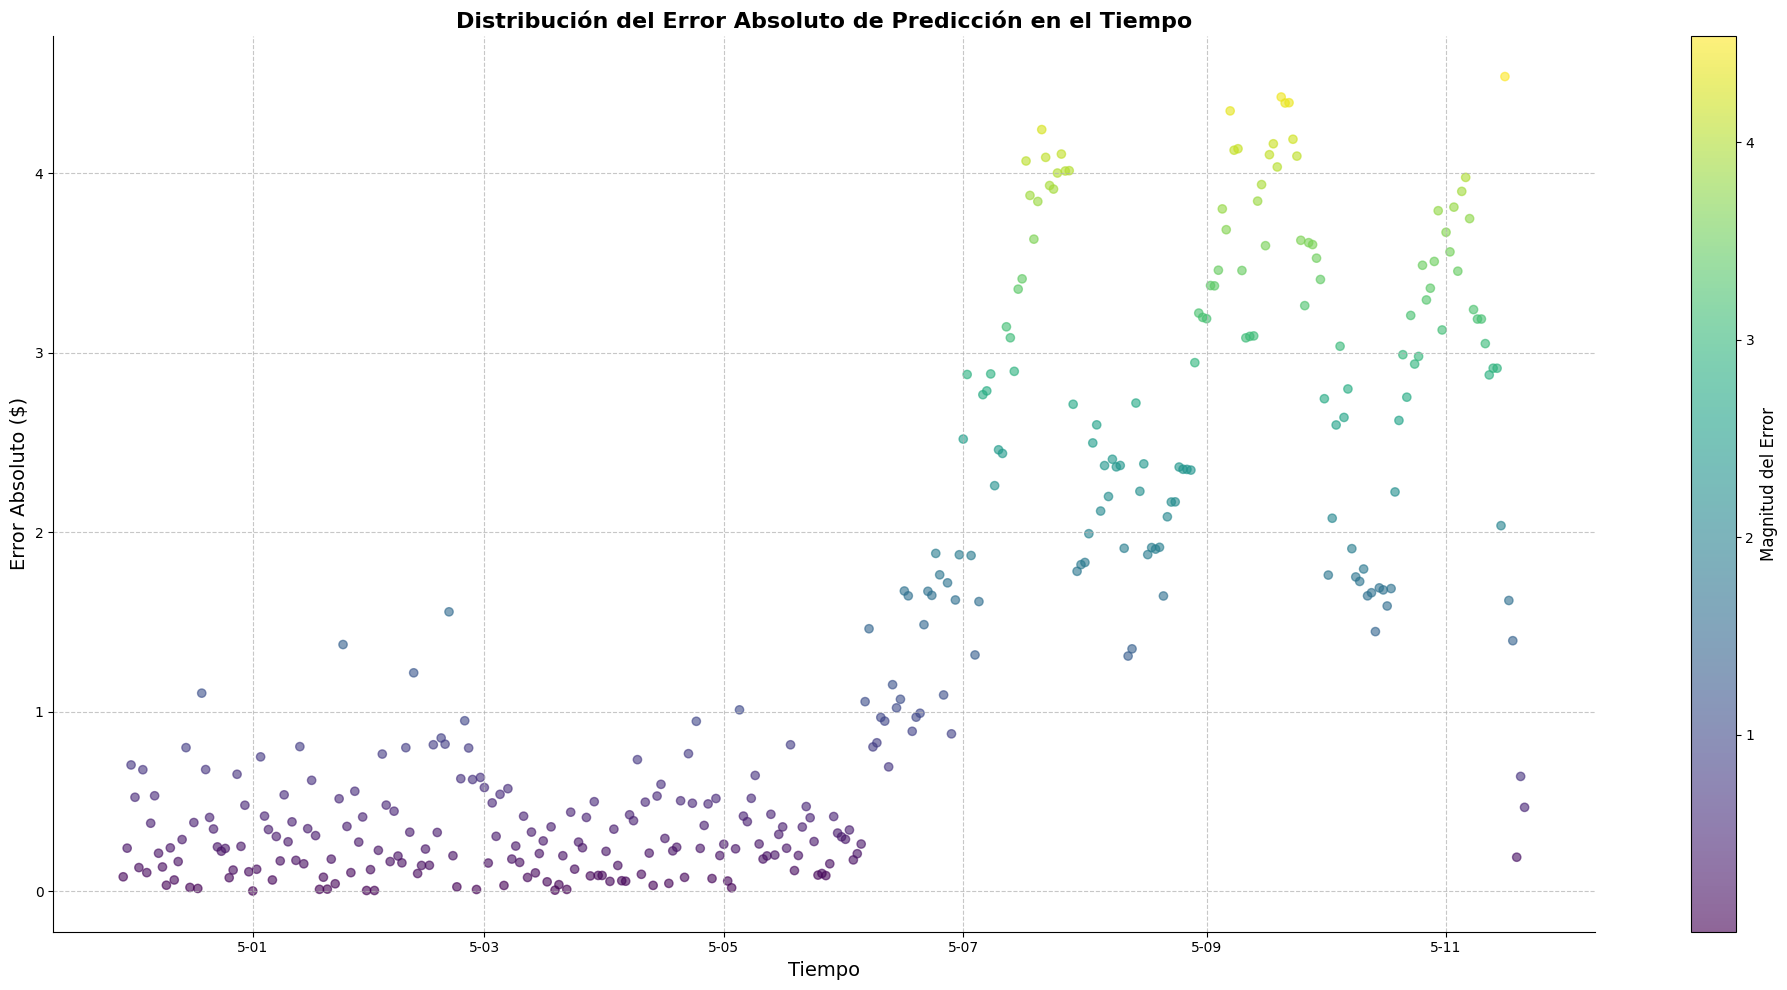

In [ ]:
# Error absoluto de predicción con gráficos de barras
error = np.abs(x_valid_denorm - rnn_forecast)

fig, ax = plt.subplots(figsize=(20, 10))
scatter = ax.scatter(time_valid, error, c=error, cmap='viridis', alpha=0.6)

ax.set_xlabel('Tiempo', fontsize=14)
ax.set_ylabel('Error Absoluto ($)', fontsize=14)
ax.set_title('Distribución del Error Absoluto de Predicción en el Tiempo', fontsize=16, fontweight='bold')

cbar = plt.colorbar(scatter)
cbar.set_label('Magnitud del Error', fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

<ipython-input-44-9a6b966dd966>:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


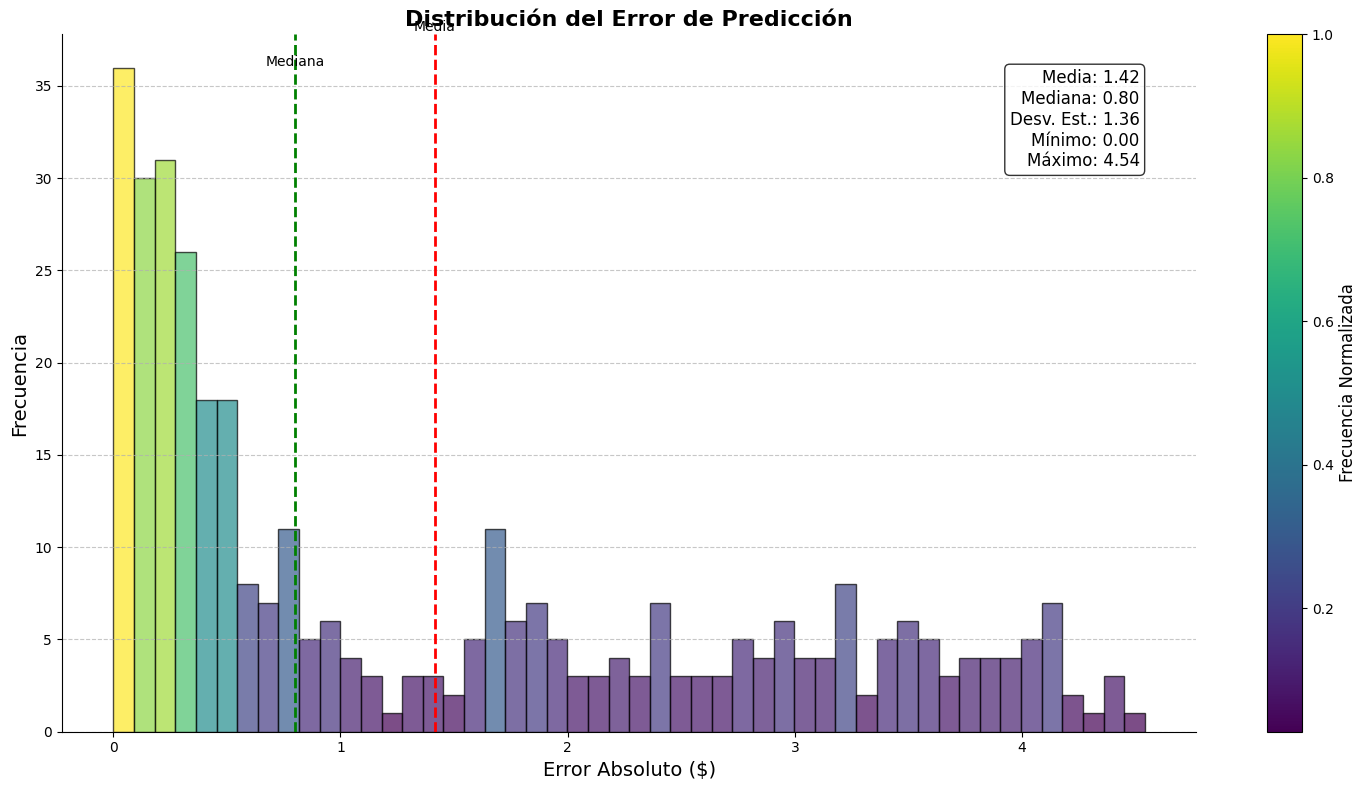

In [ ]:
# Distribución del error con gráficos de barras
fig, ax = plt.subplots(figsize=(15, 8))
n, bins, patches = ax.hist(error, bins=50, edgecolor='black', alpha=0.7)

# Colorear las barras según su altura
fracs = n / n.max()
norm = mcolors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

ax.set_xlabel('Error Absoluto ($)', fontsize=14)
ax.set_ylabel('Frecuencia', fontsize=14)
ax.set_title('Distribución del Error de Predicción', fontsize=16, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir estadísticas
stats_text = (f'Media: {error.mean():.2f}\n'
              f'Mediana: {np.median(error):.2f}\n'
              f'Desv. Est.: {error.std():.2f}\n'
              f'Mínimo: {error.min():.2f}\n'
              f'Máximo: {error.max():.2f}')

ax.text(0.95, 0.95, stats_text,
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes, fontsize=12,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Añadir una línea vertical para la media
ax.axvline(error.mean(), color='red', linestyle='dashed', linewidth=2)
ax.text(error.mean(), ax.get_ylim()[1], 'Media',
        horizontalalignment='center', verticalalignment='bottom')

# Añadir una línea vertical para la mediana
ax.axvline(np.median(error), color='green', linestyle='dashed', linewidth=2)
ax.text(np.median(error), ax.get_ylim()[1]*0.95, 'Mediana',
        horizontalalignment='center', verticalalignment='bottom')

# Añadir una barra de color
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Frecuencia Normalizada', fontsize=12)

plt.tight_layout()
plt.show()


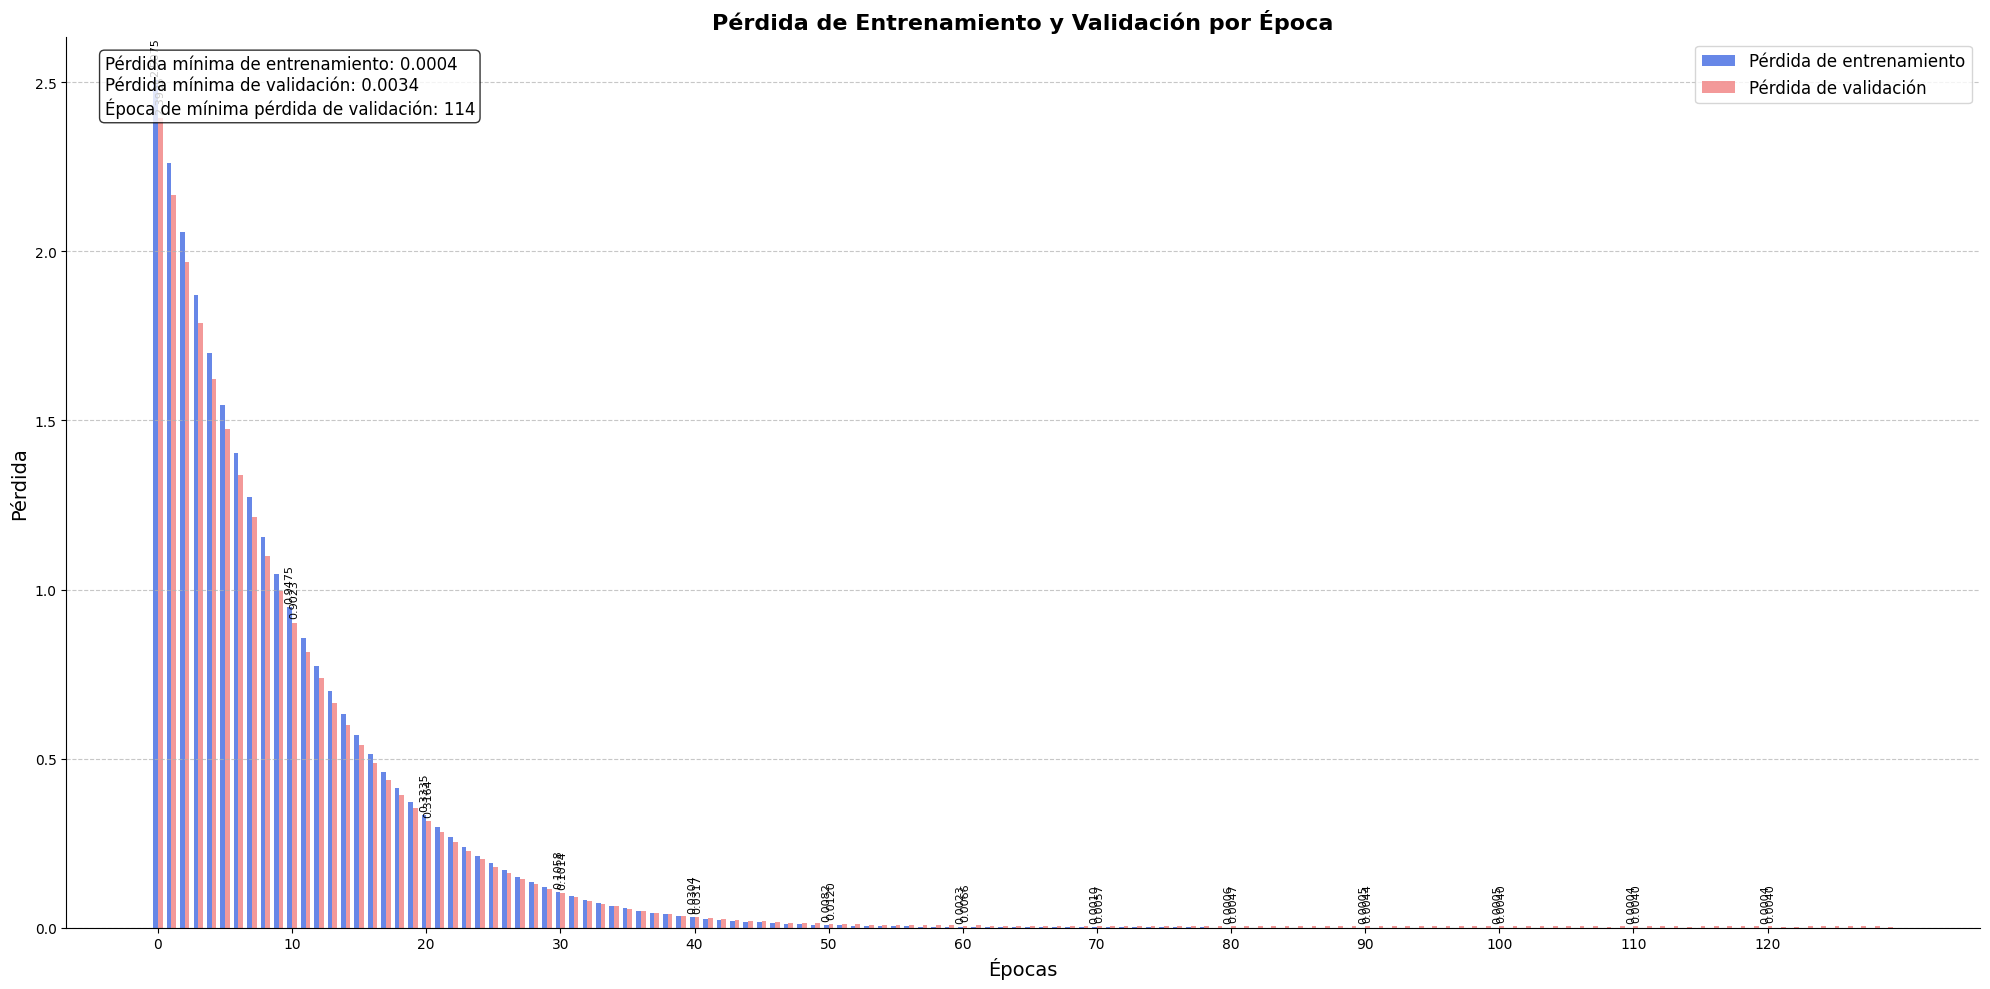

In [ ]:
# Pérdida de entrenamiento y validación con gráficos de marras
fig, ax = plt.subplots(figsize=(20, 10))

x = np.arange(len(history.history['loss']))
width = 0.35

rects1 = ax.bar(x - width/2, history.history['loss'], width, label='Pérdida de entrenamiento', color='royalblue', alpha=0.8)
rects2 = ax.bar(x + width/2, history.history['val_loss'], width, label='Pérdida de validación', color='lightcoral', alpha=0.8)

ax.set_xlabel('Épocas', fontsize=14)
ax.set_ylabel('Pérdida', fontsize=14)
ax.set_title('Pérdida de Entrenamiento y Validación por Época', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)

# Añadir etiquetas de valor en las barras (solo para algunas épocas para evitar sobrecarga visual)
def autolabel(rects, ax, step=10):
    for i, rect in enumerate(rects):
        if i % step == 0:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 puntos de desplazamiento vertical
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90, fontsize=8)

autolabel(rects1, ax)
autolabel(rects2, ax)

# Configuración adicional
ax.set_xticks(x[::10])
ax.set_xticklabels(x[::10])
ax.tick_params(axis='both', which='major', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir texto explicativo
min_train_loss = min(history.history['loss'])
min_val_loss = min(history.history['val_loss'])
epoch_min_val_loss = history.history['val_loss'].index(min_val_loss)

ax.text(0.02, 0.98, f'Pérdida mínima de entrenamiento: {min_train_loss:.4f}\n'
                    f'Pérdida mínima de validación: {min_val_loss:.4f}\n'
                    f'Época de mínima pérdida de validación: {epoch_min_val_loss}',
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

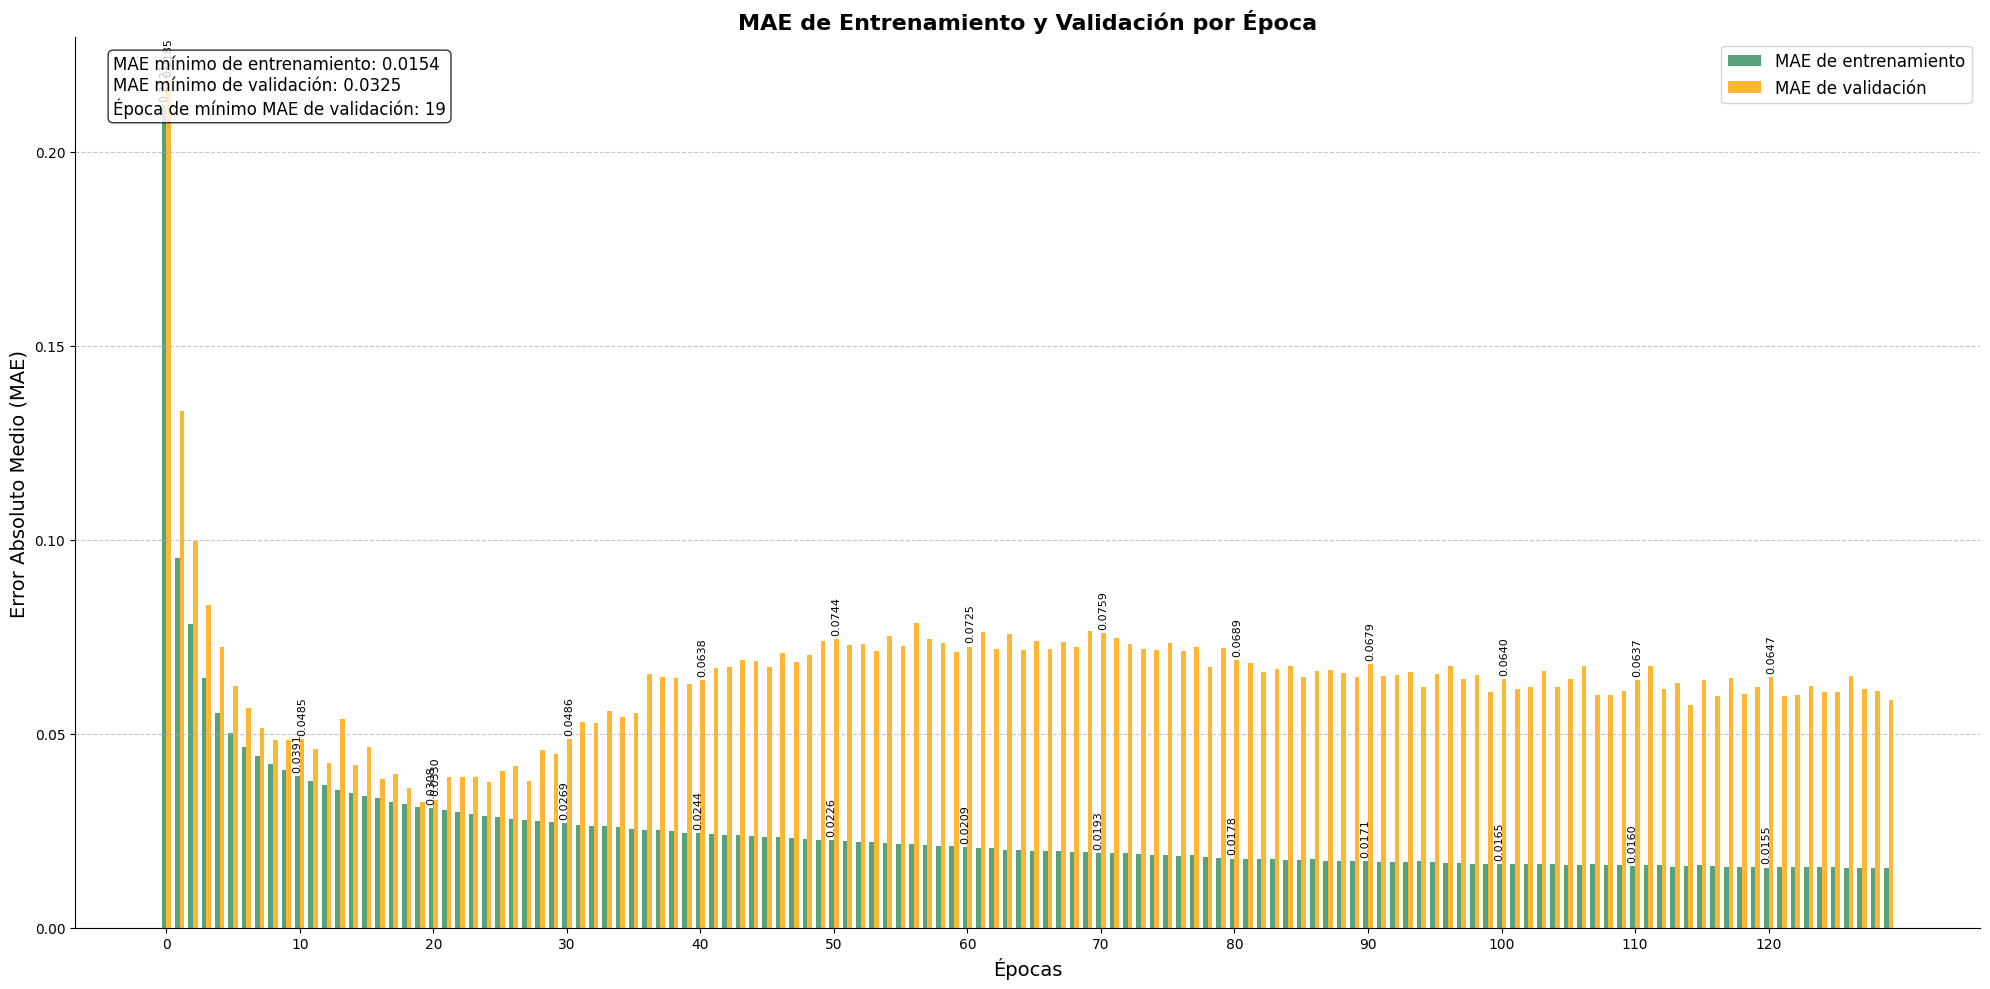

In [ ]:
# MAE de entrenamiento y validación con gráficos de barras

fig, ax = plt.subplots(figsize=(20, 10))

x = np.arange(len(history.history['mean_absolute_error']))
width = 0.35

rects1 = ax.bar(x - width/2, history.history['mean_absolute_error'], width,
                label='MAE de entrenamiento', color='seagreen', alpha=0.8)
rects2 = ax.bar(x + width/2, history.history['val_mean_absolute_error'], width,
                label='MAE de validación', color='orange', alpha=0.8)

ax.set_xlabel('Épocas', fontsize=14)
ax.set_ylabel('Error Absoluto Medio (MAE)', fontsize=14)
ax.set_title('MAE de Entrenamiento y Validación por Época', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)

# Añadir etiquetas de valor en las barras (solo para algunas épocas para evitar sobrecarga visual)
def autolabel(rects, ax, step=10):
    for i, rect in enumerate(rects):
        if i % step == 0:
            height = rect.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 puntos de desplazamiento vertical
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=90, fontsize=8)

autolabel(rects1, ax)
autolabel(rects2, ax)

# Configuración adicional
ax.set_xticks(x[::10])
ax.set_xticklabels(x[::10])
ax.tick_params(axis='both', which='major', labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir texto explicativo
min_train_mae = min(history.history['mean_absolute_error'])
min_val_mae = min(history.history['val_mean_absolute_error'])
epoch_min_val_mae = history.history['val_mean_absolute_error'].index(min_val_mae)

ax.text(0.02, 0.98, f'MAE mínimo de entrenamiento: {min_train_mae:.4f}\n'
                    f'MAE mínimo de validación: {min_val_mae:.4f}\n'
                    f'Época de mínimo MAE de validación: {epoch_min_val_mae}',
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

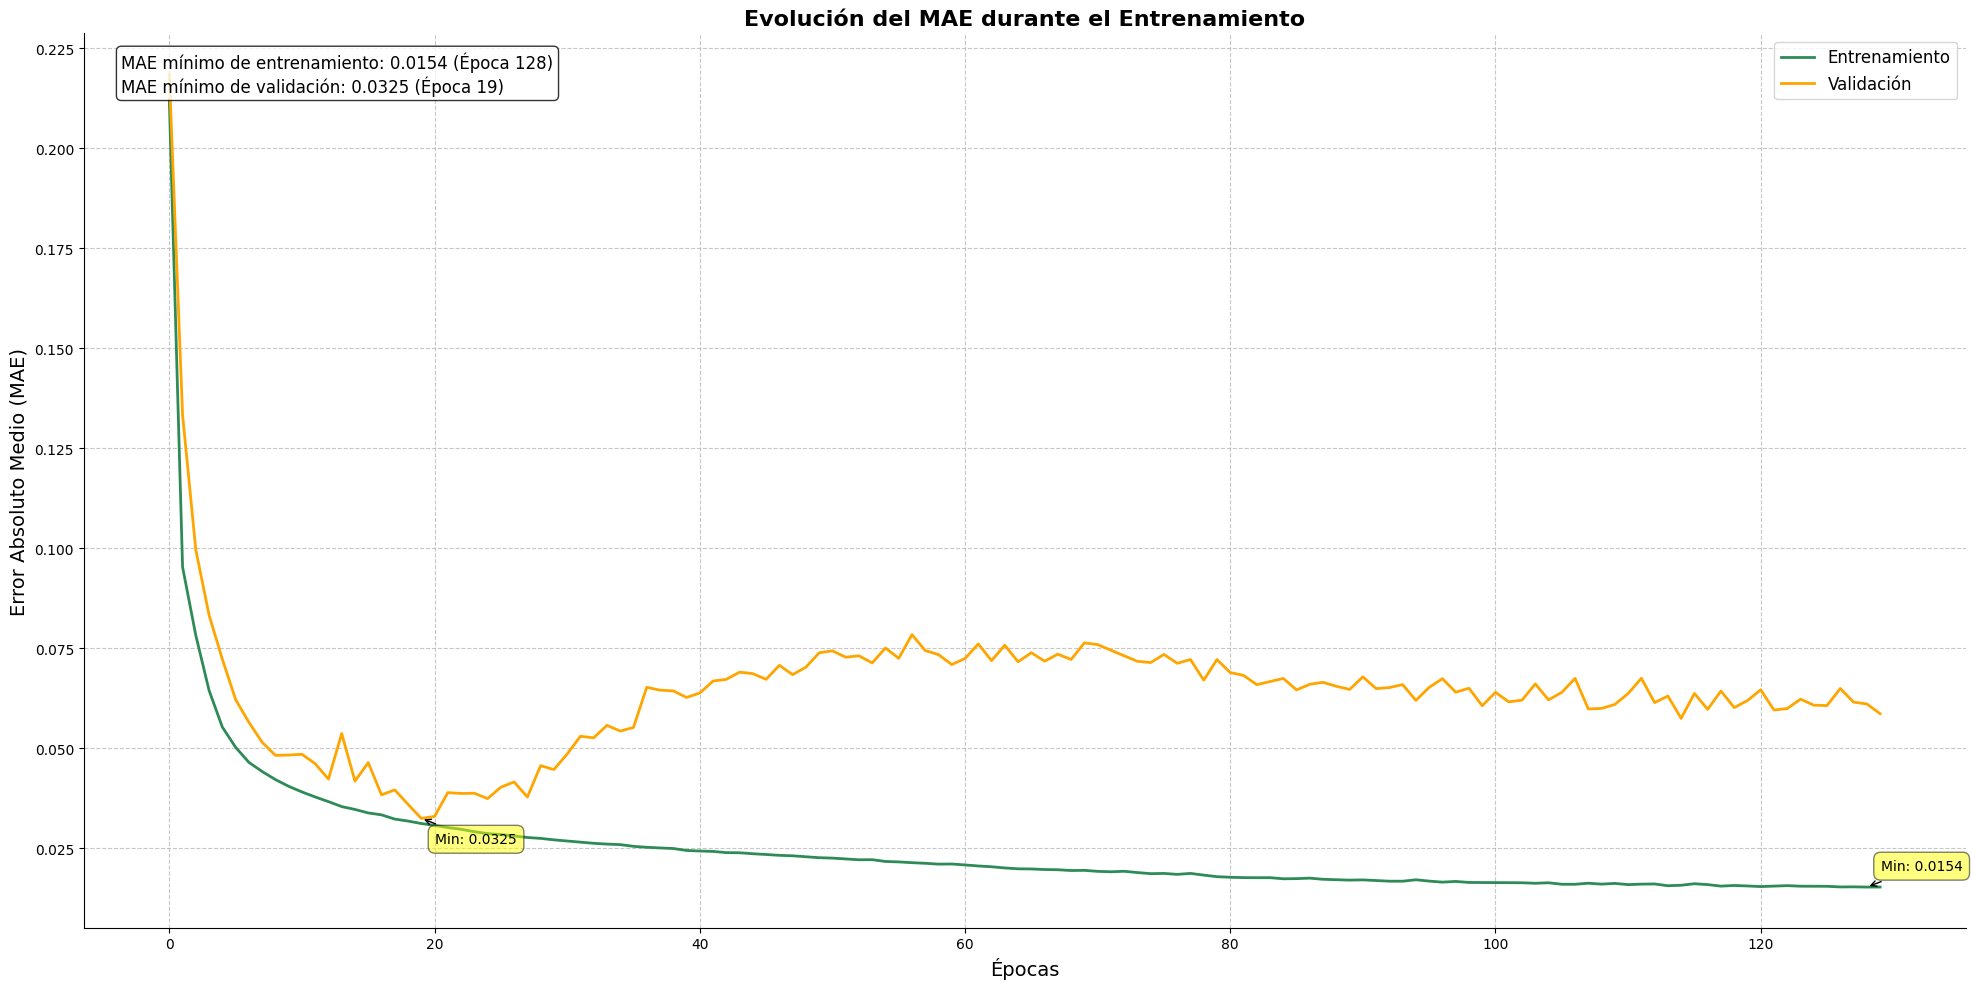

In [ ]:
# Graficar el error absoluto medio (MAE) en función de las épocas

fig, ax1 = plt.subplots(figsize=(20, 10))

# Gráfico de MAE
ax1.plot(history.history['mean_absolute_error'], label='Entrenamiento', color='seagreen', linewidth=2)
ax1.plot(history.history['val_mean_absolute_error'], label='Validación', color='orange', linewidth=2)
ax1.set_xlabel('Épocas', fontsize=14)
ax1.set_ylabel('Error Absoluto Medio (MAE)', fontsize=14)
ax1.set_title('Evolución del MAE durante el Entrenamiento', fontsize=16, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(linestyle='--', alpha=0.7)

# Mejorar la apariencia
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Añadir anotaciones para los valores mínimos
min_train_mae = min(history.history['mean_absolute_error'])
min_val_mae = min(history.history['val_mean_absolute_error'])
epoch_min_train = history.history['mean_absolute_error'].index(min_train_mae)
epoch_min_val = history.history['val_mean_absolute_error'].index(min_val_mae)

ax1.annotate(f'Min: {min_train_mae:.4f}', xy=(epoch_min_train, min_train_mae), xytext=(10, 10),
             textcoords='offset points', ha='left', va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax1.annotate(f'Min: {min_val_mae:.4f}', xy=(epoch_min_val, min_val_mae), xytext=(10, -10),
             textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Añadir texto explicativo
ax1.text(0.02, 0.98, f'MAE mínimo de entrenamiento: {min_train_mae:.4f} (Época {epoch_min_train})\n'
                     f'MAE mínimo de validación: {min_val_mae:.4f} (Época {epoch_min_val})',
         transform=ax1.transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()